In [3]:
!pip install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00


In [4]:
import cv2
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from io import BytesIO
from PIL import Image
import io
import cairosvg
#from ipywidgets import widgets
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from glob import glob
import shutil

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#untuk liat data apa saja yang ada di dalam dataset
data_dir = '/content/drive/MyDrive/dataset_sampah/'

files = os.listdir(data_dir)
print(files)

['organic', 'non-organik', 'berbahaya']


In [9]:
jumlah_image = len(list(Path(data_dir).glob('*/*.*')))
print(f"total images: {jumlah_image}")
print(f"total image non-organik: {len(os.listdir(data_dir+'./non-organik'))}")
print(f"total image berbahaya: {len(os.listdir(data_dir+'./berbahaya'))}")
print(f"total image organic: {len(os.listdir(data_dir+'./organic'))}")

total images: 1538
total image non-organik: 501
total image berbahaya: 530
total image organic: 507


In [10]:
x_data = []
y_data = []

for category in glob(data_dir+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 530/530 [00:13<00:00, 38.62it/s]


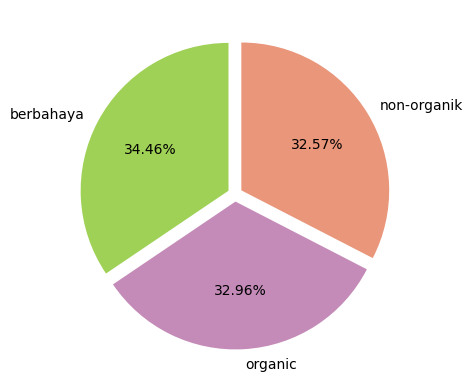

In [11]:
colors = ['#a0d157','#c48bb8','#E9967A']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05,0.05],autopct='%0.2f%%',
        labels=['berbahaya', 'organic', 'non-organik'], colors= colors,radius=1)
plt.show()

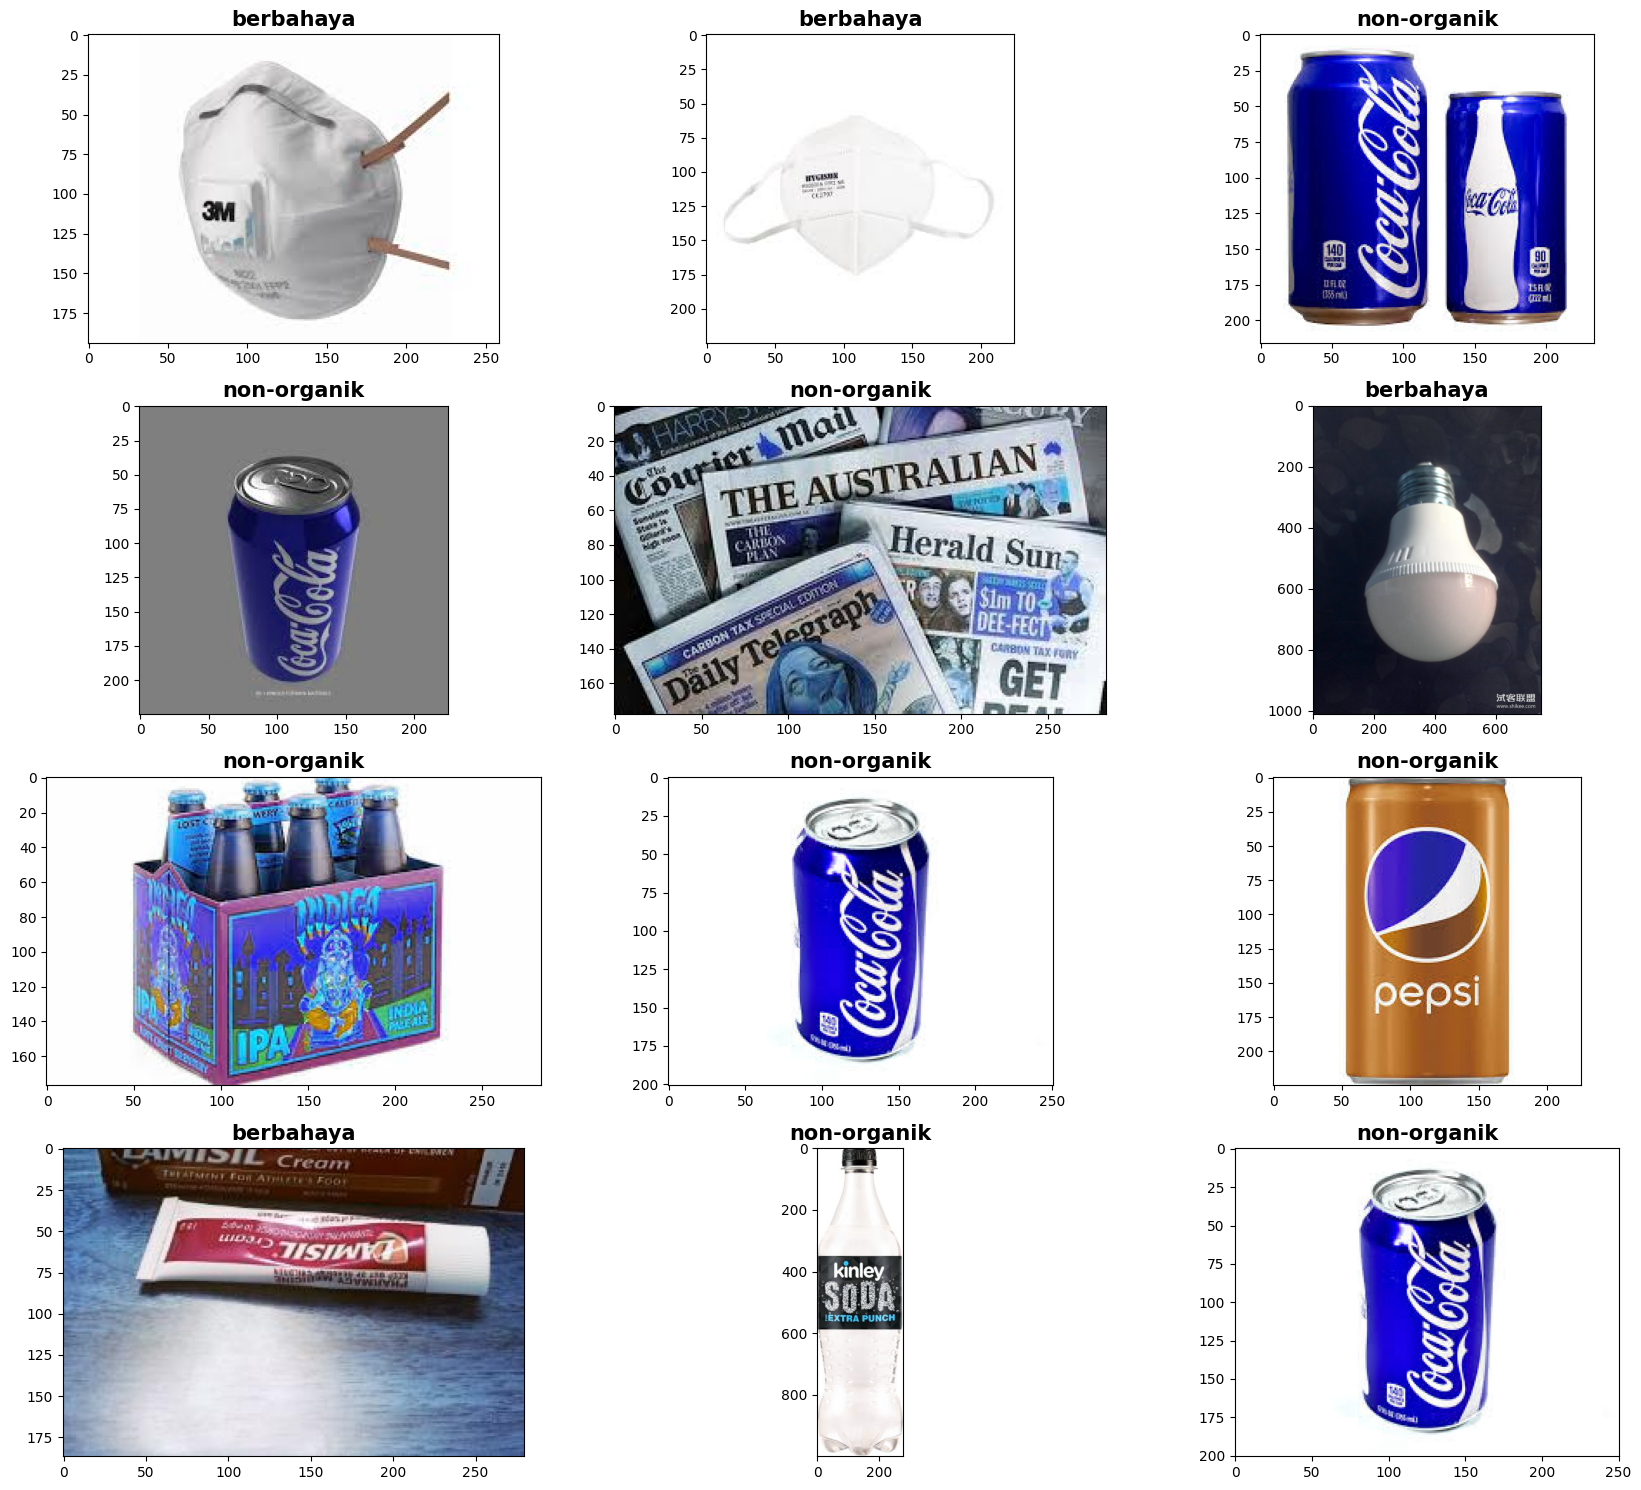

In [12]:
plt.figure(figsize=(20,15))
for i in range(12):
    plt.subplot(4,3,(i%12)+1)
    #menghasilkan indeks acak dalam batas-batas DataFrame
    index=np.random.randint(0, len(data))
    plt.title(format(data.label[index]),fontdict={'size':15, 'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [14]:
original_dataset_dir = '/content/drive/MyDrive/dataset_sampah'
split_dataset_dir = '/content/drive/MyDrive/split_dataset'

os.makedirs(split_dataset_dir, exist_ok=True)

train_ratio = 0.8

categories = [f for f in os.listdir(original_dataset_dir) if os.path.isdir(os.path.join(original_dataset_dir, f))]

for category in categories:

    category_path = os.path.join(original_dataset_dir, category)

    images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    random.shuffle(images)

    train_size = int(len(images) * train_ratio)

    train_category_dir = os.path.join(split_dataset_dir, 'train', category)
    test_category_dir = os.path.join(split_dataset_dir, 'test', category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    # copy image to train and test folder
    for i, image in enumerate(images):
        src = os.path.join(category_path, image)
        if i < train_size:
            dst = os.path.join(train_category_dir, image)
        else:
            dst = os.path.join(test_category_dir, image)
        shutil.copy(src, dst)

print("Dataset telah disalin ke folder split_dataset dengan pembagian train dan test.")

Dataset telah disalin ke folder split_dataset dengan pembagian train dan test.


In [15]:
TRAINING_DIR = "/content/drive/MyDrive/split_dataset/train"
VALIDATION_DIR = "/content/drive/MyDrive/split_dataset/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(128,128),
        batch_size =8,
        color_mode= "rgb",
        class_mode= "categorical",
        shuffle=True)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = train_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(128,128),
        batch_size =8,
        color_mode= "rgb",
        class_mode= "categorical"
)

Found 1446 images belonging to 3 classes.
Found 1173 images belonging to 3 classes.


Membuat Model CNN

In [16]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output layer
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,783,171 (10.62 MB)

 Trainable params: 2,782,211 (10.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
          train_generator,
          validation_data= validation_generator,
          epochs= 50,
          callbacks=[early_stopping]
          )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/181 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - accuracy: 0.3995 - loss: 12.2009

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


181/181 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.4186 - loss: 11.9680 - val_accuracy: 0.3845 - val_loss: 10.5665
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.4887 - loss: 10.6793 - val_accuracy: 0.4604 - val_loss: 10.2647
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.5510 - loss: 10.1762 - val_accuracy: 0.6752 - val_loss: 9.6727
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 34s 185ms/step - accuracy: 0.5387 - loss: 9.8494 - val_accuracy: 0.6905 - val_loss: 9.3433
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.5584 - loss: 9.4940 - val_accuracy: 0.7050 - val_loss: 8.9940
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.5861 - loss: 9.1052 - val_accuracy: 0.6905 - val_loss: 8.6281
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 34s 184ms/step - accuracy: 0.5830 - loss: 8.7342 - val_accuracy: 0.7357 - val_loss: 8.2476
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 42s 192ms/step - accuracy: 0.5891 - loss: 8.3658 - 

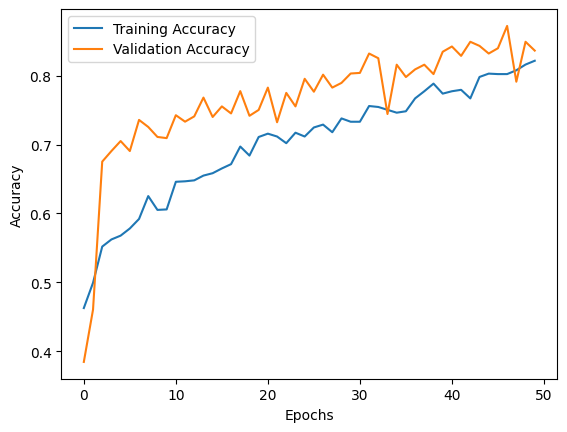

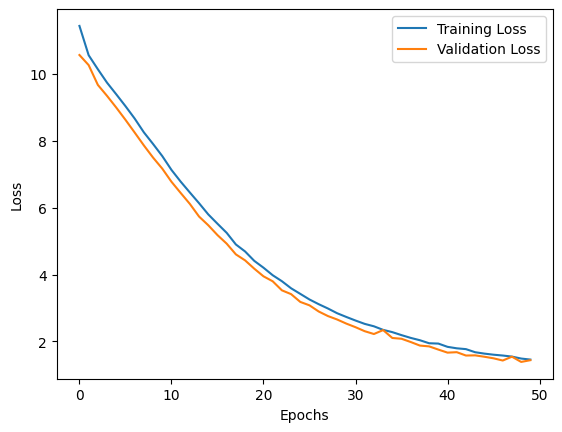

In [20]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
class_names = sorted(data['label'].unique())

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = list(validation_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step
Confusion Matrix
[[189 115 128]
 [161 111 125]
 [134  85 125]]
Classification Report
              precision    recall  f1-score   support

   berbahaya       0.39      0.44      0.41       432
 non-organik       0.36      0.28      0.31       397
     organic       0.33      0.36      0.35       344

    accuracy                           0.36      1173
   macro avg       0.36      0.36      0.36      1173
weighted avg       0.36      0.36      0.36      1173



In [25]:
def preprocess_image(image_path, target_size=(128, 128)):
    """Preprocess the input image and return it as a tensor."""
    # Handle SVG files
    if image_path.endswith('.svg'):
        with open(image_path, 'rb') as f:
            svg_data = f.read()
        png_data = cairosvg.svg2png(bytestring=svg_data)
        image = Image.open(io.BytesIO(png_data))
    else:
        image = Image.open(image_path)

    # Convert image to RGB if needed
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Resize image
    image = image.resize(target_size)

    # Convert to array and normalize
    image_array = np.array(image) / 255.0

    # Add batch dimension
    image_tensor = tf.expand_dims(image_array, axis=0)
    return image_tensor, image

def predict_and_visualize(model, image_tensor, original_image, class_names):
    # Make predictions
    predictions = model.predict(image_tensor)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    # Visualize the result
    plt.imshow(original_image)
    plt.title(f"Predicted: {predicted_class_name}\nConfidence: {predictions[0][predicted_class_index]:.2f}",
              fontdict={'size': 15, 'weight': 'bold'})
    plt.axis('off')
    plt.show()

    return predicted_class_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


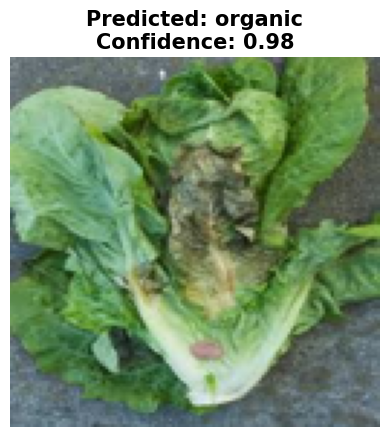

Predicted Class: organic


In [28]:
image_path = "/content/drive/MyDrive/testing_img/org (94).jfif"
class_names = list(train_generator.class_indices.keys())

# Load and preprocess image
image_tensor, original_image = preprocess_image(image_path)

# Predict and visualize
predicted_class_name = predict_and_visualize(model, image_tensor, original_image, class_names)
print(f"Predicted Class: {predicted_class_name}")

In [29]:
model.save('model_kategorisampah.h5')